In [120]:
# 0. Import all libraries
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import datetime as dt
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import seaborn as sns

In [121]:
# 1. Import data
file_path = './data/merged_data.csv'
data = pd.read_csv(file_path)

In [122]:
# 2. Preparing Data
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)
data = data.sort_index(ascending=True)

# Subset data for the specified date range
start_date = '2014-06-24'
end_date = '2024-06-21'
data = data[(data.index >= start_date) & (data.index <= end_date)]

In [123]:
# 3. Descriptive statistics
print(data.describe())

            DPRIME   Close/Last        Volume         Open         High  \
count  2516.000000  2516.000000  2.516000e+03  2516.000000  2516.000000   
mean      4.659777    83.135227  1.053906e+06    83.038848    85.631164   
std       1.746143   175.929359  2.374987e+06   176.078881   182.858264   
min       3.250000    11.650000  3.038000e+03    11.550000    12.160000   
25%       3.250000    23.035000  2.295038e+05    23.000000    23.472500   
50%       4.000000    27.955000  3.733460e+05    28.005000    28.555000   
75%       5.500000    40.150000  7.029622e+05    40.132500    40.702450   
max       8.500000  1188.070000  3.403834e+07  1212.000000  1229.000000   

               Low  
count  2516.000000  
mean     80.514331  
std     168.801560  
min       8.500000  
25%      22.630000  
50%      27.500000  
75%      39.330000  
max    1122.340000  


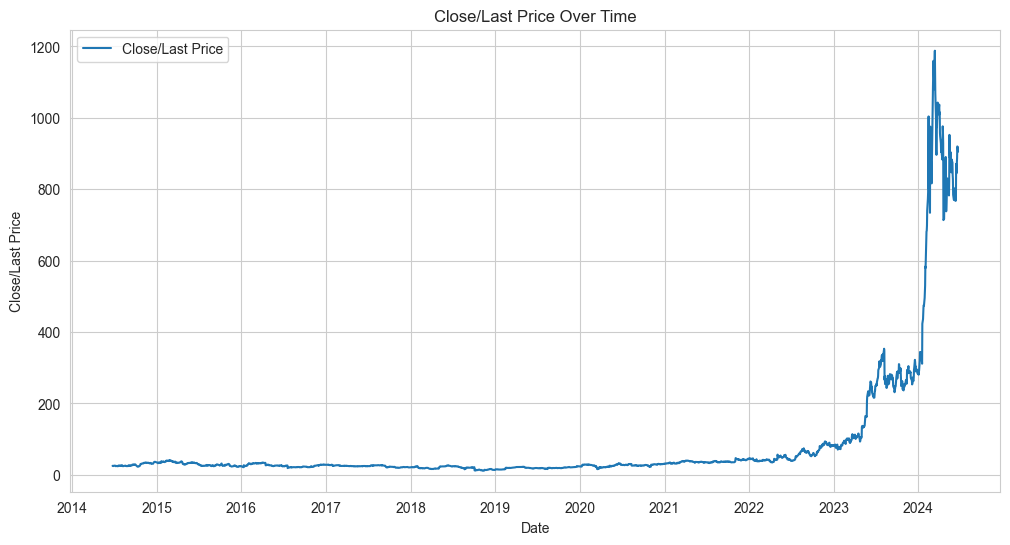

In [124]:
# 4. Visualizing the Close/Last price over time

plt.figure(figsize=(12, 6))
plt.plot(data.index, data['Close/Last'], label='Close/Last Price')
plt.title('Close/Last Price Over Time')
plt.xlabel('Date')
plt.ylabel('Close/Last Price')
plt.legend()
plt.show()


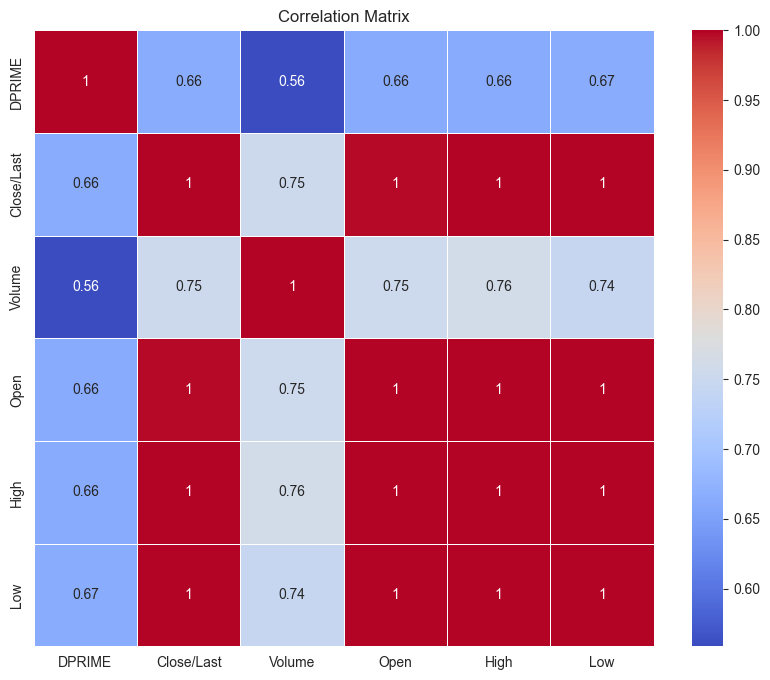

In [125]:
# 5. Correlation

# Correlation matrix
correlation_matrix = data.corr()

# Plotting the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()


In [126]:
# 6. Feature Engineering

# Adding moving averages
data['MA_10'] = data['Close/Last'].rolling(window=10).mean()
data['MA_50'] = data['Close/Last'].rolling(window=50).mean()

# Adding lag features
data['Lag_1'] = data['Close/Last'].shift(1)
data['Lag_5'] = data['Close/Last'].shift(5)
data['Lag_30'] = data['Close/Last'].shift(30)
data['Lag_60'] = data['Close/Last'].shift(60)
data['Lag_90'] = data['Close/Last'].shift(90)

# Drop rows with NaN values (created by rolling and shifting)
data.dropna(inplace=True)


[ 1.          0.99298379  0.98605709 ... -0.08324422 -0.08320433
 -0.08316042]
0.36742558815167403
Statistically significant lags: []


<Figure size 1200x600 with 0 Axes>

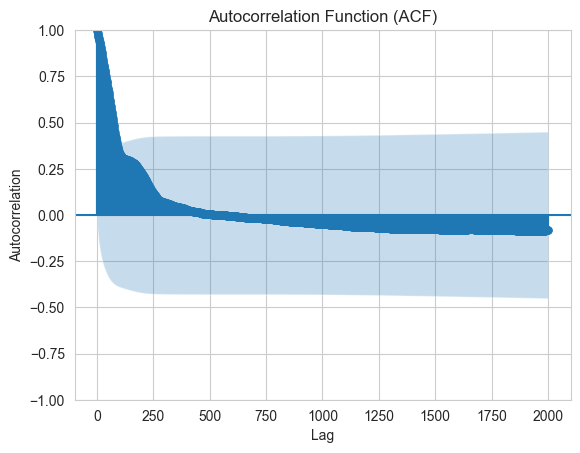

In [135]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import acf

# 计算自相关函数（ACF）
acf_values, confint = acf(data['Close/Last'], nlags=2000, alpha=0.05)  # 95% 置信区间
print(acf_values)

# 找出统计显著的滞后期
significant_lags = []
for lag in range(len(acf_values)):
    lower_bound, upper_bound = confint[lag]
    if acf_values[lag] < lower_bound or acf_values[lag] > upper_bound:
        significant_lags.append(lag)

print(upper_bound)
# 打印统计显著的滞后期
print(f"Statistically significant lags: {significant_lags}")

# 可视化 ACF 结果
plt.figure(figsize=(12, 6))
plot_acf(data['Close/Last'], lags=2000, alpha=0.05)
plt.title('Autocorrelation Function (ACF)')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.show()

In [128]:

# 计算自相关系数
acf_values = acf(data['Close/Last'], nlags=100)

# 打印特定滞后期的自相关系数
print(f"Lag 30: {acf_values[30]}")
print(f"Lag 60: {acf_values[60]}")
print(f"Lag 90: {acf_values[90]}")


Lag 30: 0.8060733555296623
Lag 60: 0.5910968181746147
Lag 90: 0.3730846022421395


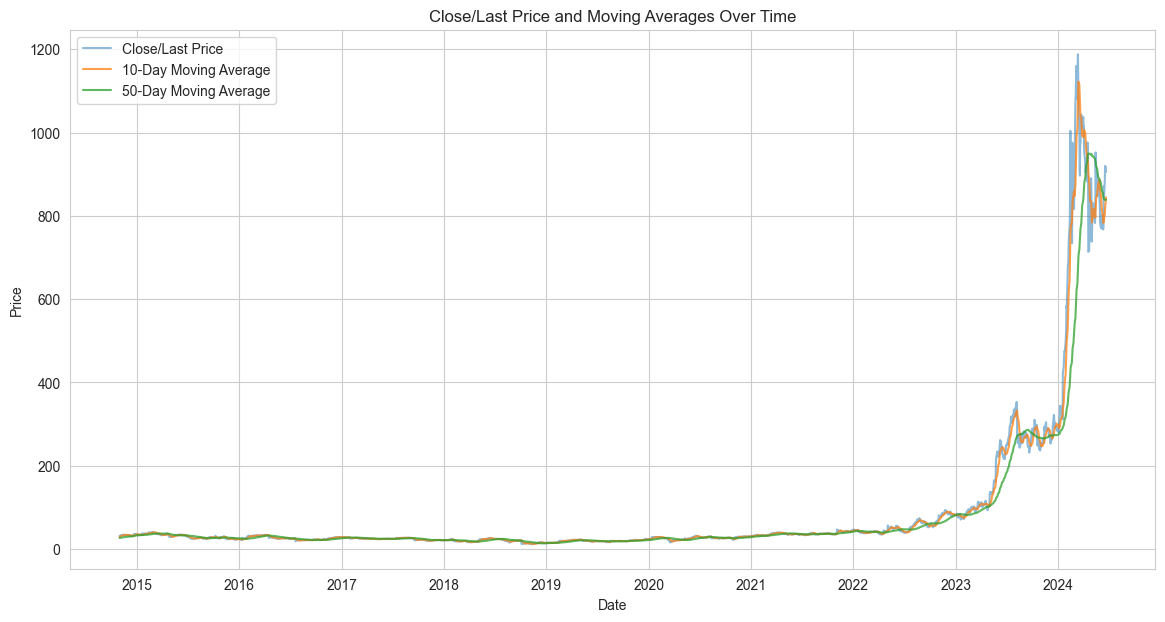

In [111]:
# 6.1  Plotting the Close/Last price with moving averages
plt.figure(figsize=(14, 7))
plt.plot(data.index, data['Close/Last'], label='Close/Last Price', alpha=0.5)
plt.plot(data.index, data['MA_10'], label='10-Day Moving Average', alpha=0.75)
plt.plot(data.index, data['MA_50'], label='50-Day Moving Average', alpha=0.75)
plt.title('Close/Last Price and Moving Averages Over Time')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()


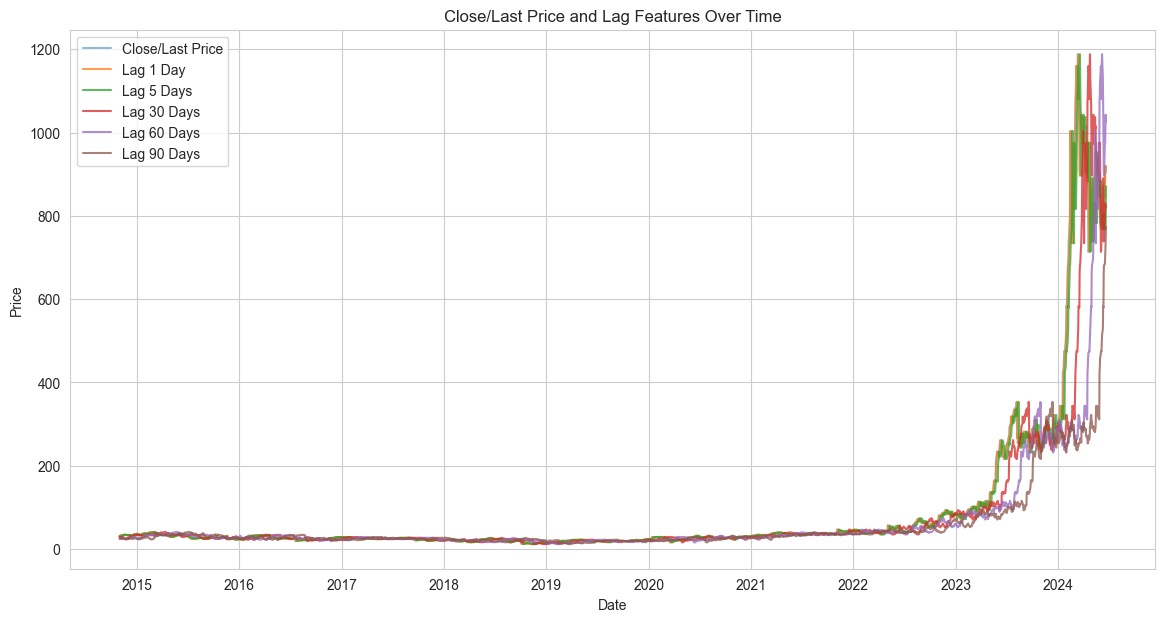

In [112]:
# 6.2 Plotting the Close/Last price with lag features
plt.figure(figsize=(14, 7))
plt.plot(data.index, data['Close/Last'], label='Close/Last Price', alpha=0.5)
plt.plot(data.index, data['Lag_1'], label='Lag 1 Day', alpha=0.75)
plt.plot(data.index, data['Lag_5'], label='Lag 5 Days', alpha=0.75)
plt.plot(data.index, data['Lag_30'], label='Lag 30 Days', alpha=0.75)
plt.plot(data.index, data['Lag_60'], label='Lag 60 Days', alpha=0.75)
plt.plot(data.index, data['Lag_90'], label='Lag 90 Days', alpha=0.75)
plt.title('Close/Last Price and Lag Features Over Time')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()


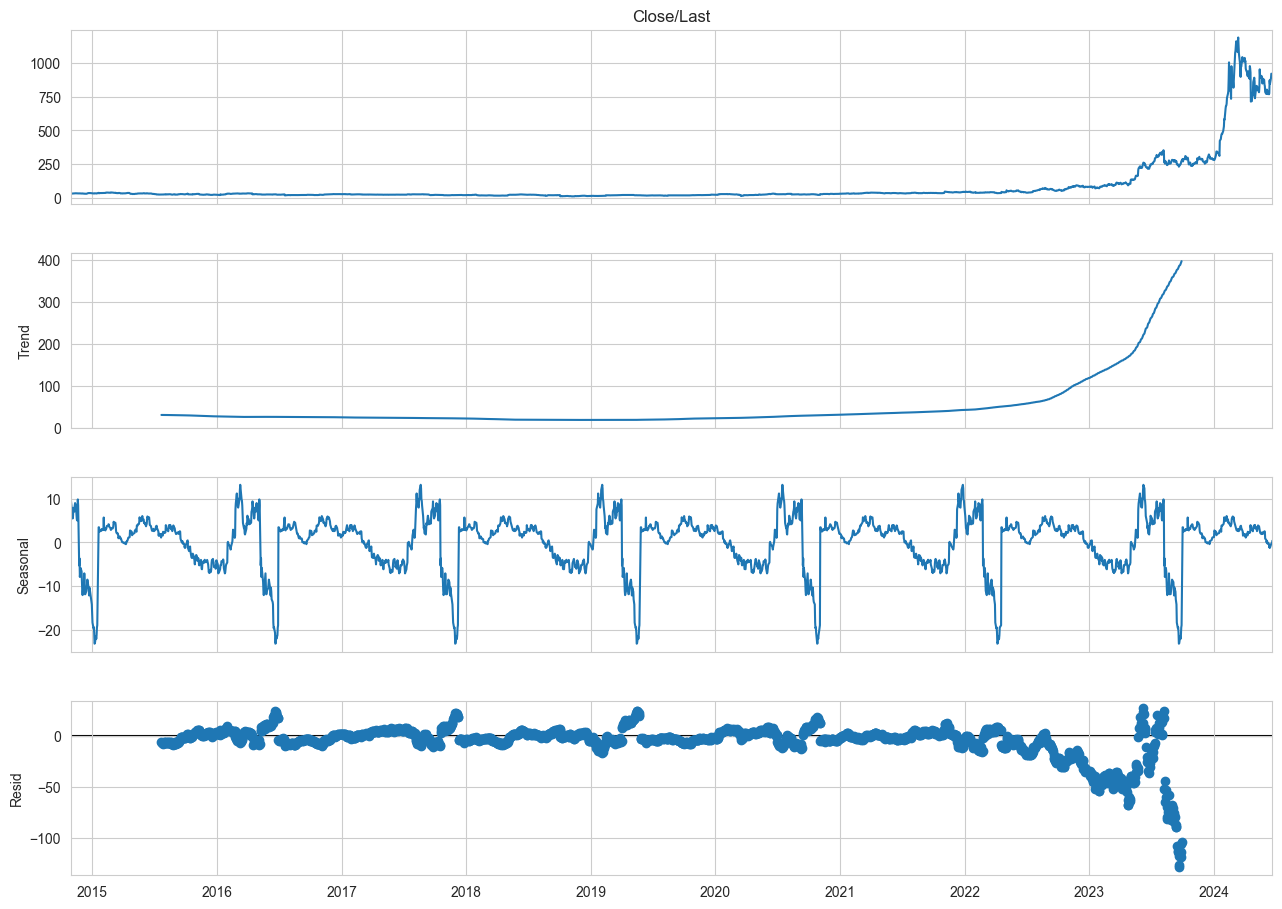

In [113]:
import statsmodels.api as sm

# 7. Decompose the time series to observe trend, seasonality, and residuals
decomposition = sm.tsa.seasonal_decompose(data['Close/Last'], model='additive', period=365)
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

fig = decomposition.plot()
fig.set_size_inches(14, 10)
plt.show()


In [114]:
# Save each component to a DataFrame
trend_df = pd.DataFrame({'Date': trend.index, 'Trend': trend.values}).dropna()
seasonal_df = pd.DataFrame({'Date': seasonal.index, 'Seasonal': seasonal.values}).dropna()
residual_df = pd.DataFrame({'Date': residual.index, 'Residual': residual.values}).dropna()

# # Print the first few rows of each DataFrame
# print("Trend DataFrame:")
# print(trend_df.head())
# print("\nSeasonal DataFrame:")
# print(seasonal_df.head())
# print("\nResidual DataFrame:")
# print(residual_df.head())

In [115]:
# 7.1 Trend Component: Calculate the slope
trend.dropna(inplace=True)  # Drop NaN values
X = np.arange(len(trend)).reshape(-1, 1)
y = trend.values
model = LinearRegression().fit(X, y)
slope = model.coef_[0]
print(f"Trend Slope: {slope}")

# 7.2 Seasonal Component: Calculate the amplitude
seasonal_max = seasonal.max()
seasonal_min = seasonal.min()
amplitude = seasonal_max - seasonal_min
print(f"Seasonal Amplitude: {amplitude}")

# 7.3 Residual Component: Calculate the standard deviation
residual_std = residual.std()
print(f"Residual Standard Deviation: {residual_std}")

Trend Slope: 0.0611576496007314
Seasonal Amplitude: 36.44594977168952
Residual Standard Deviation: 16.76784056654376


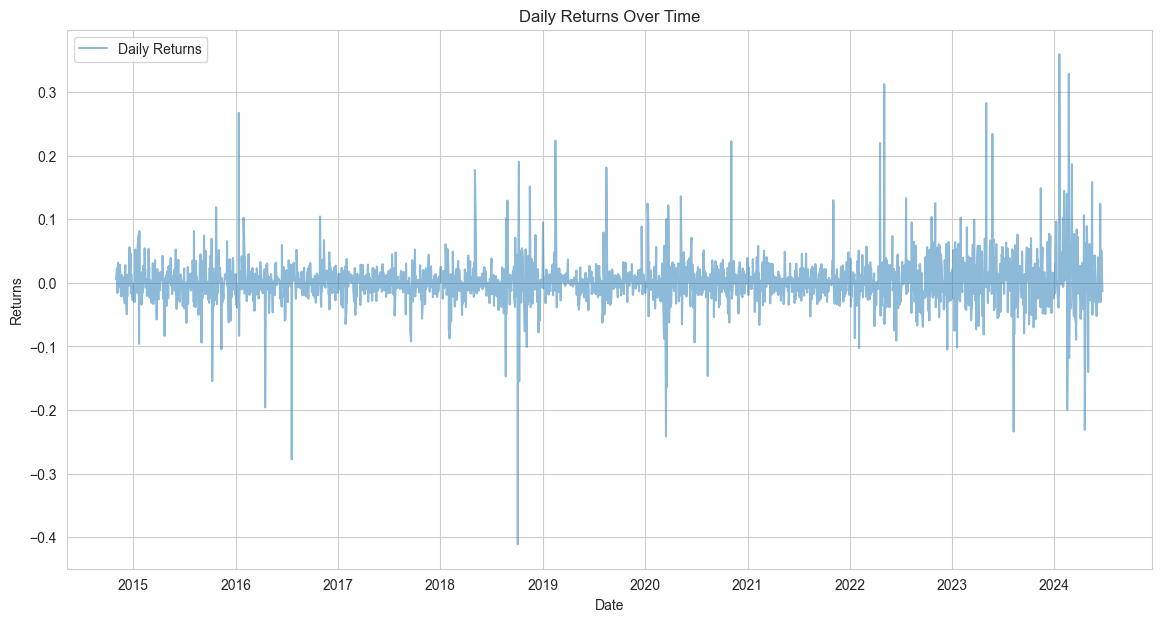

In [116]:
# Calculate the daily returns
data['Daily_Returns'] = data['Close/Last'].pct_change()

# Plotting the daily returns
plt.figure(figsize=(14, 7))
plt.plot(data.index, data['Daily_Returns'], label='Daily Returns', alpha=0.5)
plt.title('Daily Returns Over Time')
plt.xlabel('Date')
plt.ylabel('Returns')
plt.legend()
plt.show()


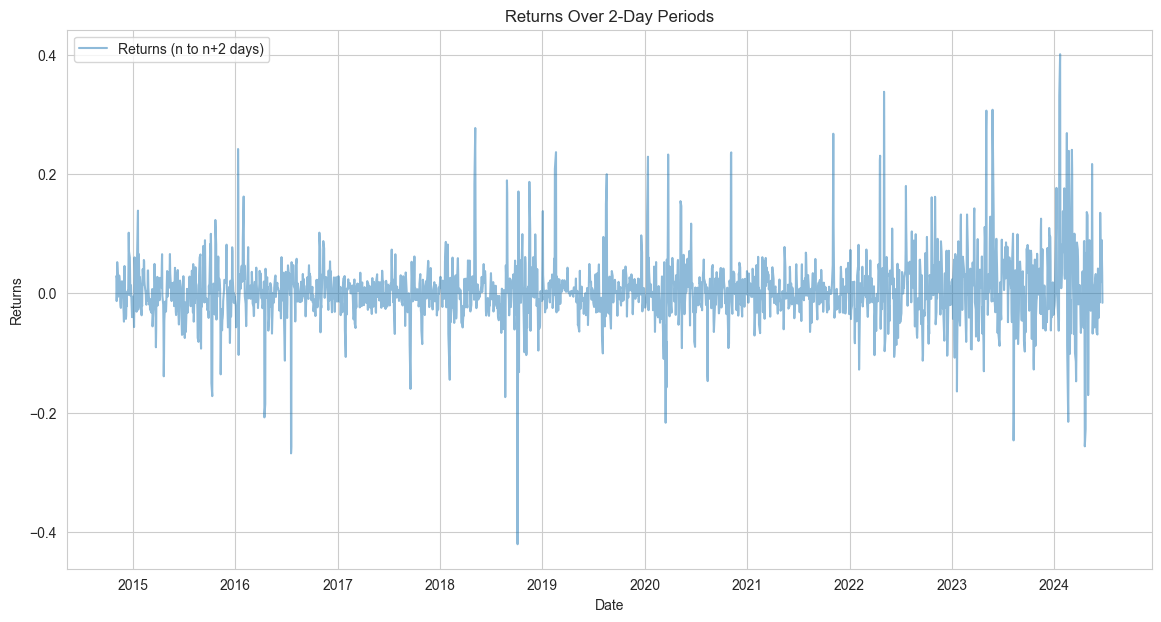

In [117]:
# Calculate the returns between n and n+2 days
data['Returns_n_to_n+2'] = data['Close/Last'].pct_change(periods=2)

# Plotting the n to n+2 day returns
plt.figure(figsize=(14, 7))
plt.plot(data.index, data['Returns_n_to_n+2'], label='Returns (n to n+2 days)', alpha=0.5)
plt.title('Returns Over 2-Day Periods')
plt.xlabel('Date')
plt.ylabel('Returns')
plt.legend()
plt.show()

Returns (n to n+10 days) Metrics:
Mean Return: 0.023168681993389346
Standard Deviation: 0.12648686450846378
Annualized Return: 320.14715777732107
Sharpe Ratio: 2.907744025335375

Returns (n to n+30 days) Metrics:
Mean Return: 0.07567149944108907
Standard Deviation: 0.2806586536447042
Annualized Return: 96222091.09153369
Sharpe Ratio: 4.280102528602633

Returns (n to n+365 days) Metrics:
Mean Return: 1.2403968418699942
Standard Deviation: 2.9337656096606994
Annualized Return: 1.913761680003219e+88
Sharpe Ratio: 6.7117459414164955


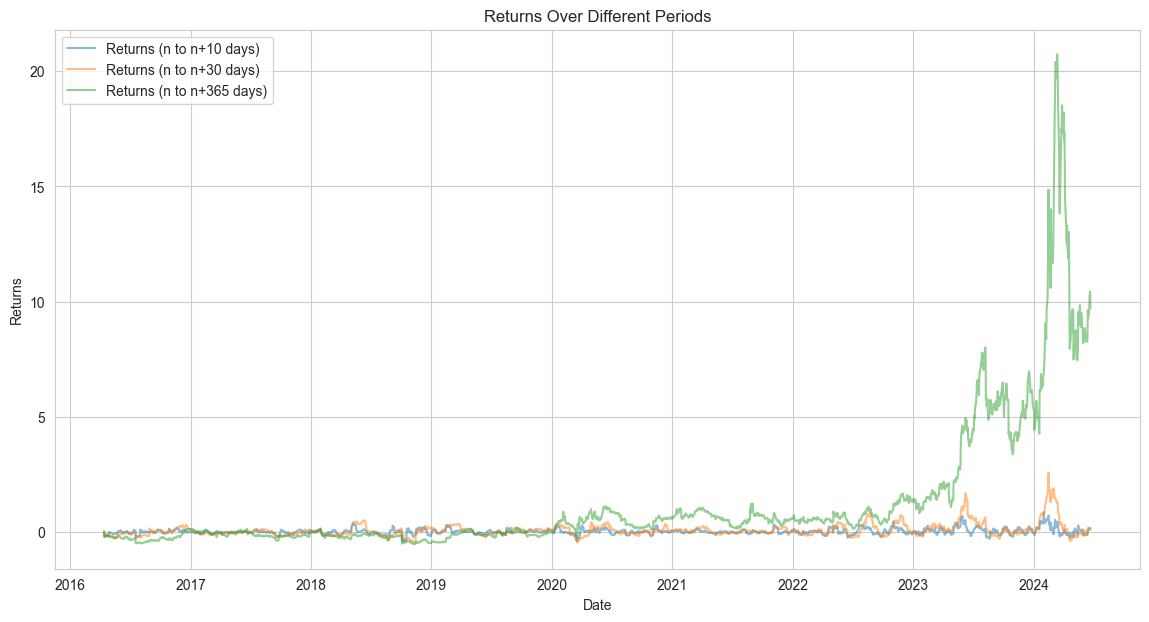

In [118]:
# Calculate returns for different periods
data['Returns_n_to_n+10'] = data['Close/Last'].pct_change(periods=10)
data['Returns_n_to_n+30'] = data['Close/Last'].pct_change(periods=30)
data['Returns_n_to_n+365'] = data['Close/Last'].pct_change(periods=365)

# Drop NaN values
data.dropna(inplace=True)

# Define a function to calculate performance metrics
def calculate_performance_metrics(returns, risk_free_rate=0.0):
    mean_return = returns.mean()
    std_dev = returns.std()
    annualized_return = ((1 + mean_return) ** 252) - 1  # Assuming 252 trading days in a year
    sharpe_ratio = (mean_return - risk_free_rate) / std_dev * np.sqrt(252)
    
    return {
        "Mean Return": mean_return,
        "Standard Deviation": std_dev,
        "Annualized Return": annualized_return,
        "Sharpe Ratio": sharpe_ratio
    }

# Calculate metrics for n to n+10 day returns
n_to_n_plus_10_metrics = calculate_performance_metrics(data['Returns_n_to_n+10'])

# Calculate metrics for n to n+30 day returns
n_to_n_plus_30_metrics = calculate_performance_metrics(data['Returns_n_to_n+30'])

# Calculate metrics for n to n+365 day returns
n_to_n_plus_365_metrics = calculate_performance_metrics(data['Returns_n_to_n+365'])

# Print the performance metrics
print("Returns (n to n+10 days) Metrics:")
for key, value in n_to_n_plus_10_metrics.items():
    print(f"{key}: {value}")

print("\nReturns (n to n+30 days) Metrics:")
for key, value in n_to_n_plus_30_metrics.items():
    print(f"{key}: {value}")

print("\nReturns (n to n+365 days) Metrics:")
for key, value in n_to_n_plus_365_metrics.items():
    print(f"{key}: {value}")

# Plotting the returns for visualization
plt.figure(figsize=(14, 7))
plt.plot(data.index, data['Returns_n_to_n+10'], label='Returns (n to n+10 days)', alpha=0.5)
plt.plot(data.index, data['Returns_n_to_n+30'], label='Returns (n to n+30 days)', alpha=0.5)
plt.plot(data.index, data['Returns_n_to_n+365'], label='Returns (n to n+365 days)', alpha=0.5)
plt.title('Returns Over Different Periods')
plt.xlabel('Date')
plt.ylabel('Returns')
plt.legend()
plt.show()

In [119]:
data

,DPRIME,Close/Last,Volume,Open,High,Low,MA_10,MA_50,Lag_1,Lag_5,Lag_30,Lag_60,Lag_90,Daily_Returns,Returns_n_to_n+2,Returns_n_to_n+10,Returns_n_to_n+30,Returns_n_to_n+365
Date,,,,,,,,,,,,,,,,,,
2016-04-14,3.5,33.320,312399,33.92,33.9400,32.850,33.7420,32.5268,33.830,33.66,33.19,24.78,26.40,-0.015075,0.005735,-0.022300,0.003917,0.048458
2016-04-15,3.5,26.790,3079999,28.50,29.3900,26.695,32.9720,32.4202,33.320,33.37,33.61,25.22,26.54,-0.195978,-0.208099,-0.223253,-0.202916,-0.161765
2016-04-18,3.5,27.130,832558,26.72,27.4300,26.100,32.2820,32.3168,26.790,33.18,32.63,24.96,24.89,0.012691,-0.185774,-0.202762,-0.168557,-0.169829
2016-04-19,3.5,27.890,580502,27.32,28.3200,27.150,31.6530,32.2352,27.130,33.13,32.83,25.99,25.25,0.028013,0.041060,-0.184026,-0.150472,-0.148917
2016-04-20,3.5,27.980,499526,27.84,28.6820,27.710,31.0280,32.1602,27.890,33.83,31.38,26.11,23.94,0.003227,0.031331,-0.182588,-0.108349,-0.132403
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-06-14,8.5,844.540,6598781,846.93,872.0000,825.610,793.6600,839.7714,871.100,769.11,762.52,896.47,681.59,-0.030490,0.090095,0.076519,0.107564,9.286724
2024-06-17,8.5,887.410,8911764,857.40,921.9100,828.090,805.3420,838.5592,844.540,786.86,782.70,971.61,683.60,0.050761,0.018723,0.151598,0.133781,9.582041
2024-06-18,8.5,920.010,8762073,897.00,938.8800,883.310,820.1820,838.3894,887.410,767.61,830.35,972.74,698.00,0.036736,0.089362,0.192325,0.107979,10.185532


============

In [ ]:

train_set = data[(data['Date'] >= '2014-06-24') & (data['Date'] < '2023-06-24')].copy()
valid_set = data[(data['Date'] >= '2022-06-25') & (data['Date'] <= '2024-06-21')].copy()

# # Split data
# total_length = len(data)
# train_length = int(total_length * 0.70)
# train_set = data.iloc[:train_length].copy()
# valid_set = data.iloc[train_length:].copy()


In [7]:
# 2. Setup Variables
# 2.1 Time horizon set to be 9 years for training, 1 year for validation
# 2.2 time steps for LSTM
time_steps = 60     # tested [30, 60, 90, 120], 90 is the most efficient one

In [8]:
# 3. Data pre-processing
scaler = MinMaxScaler(feature_range=(0, 1))

# Normalize the 'Close/Last' column for both training and validation sets
train_data = scaler.fit_transform(train_set['Close/Last'].values.reshape(-1, 1))
valid_data = scaler.transform(valid_set['Close/Last'].values.reshape(-1, 1))

# Initialize lists to store training and validation data
x_train, y_train = [], []
for i in range(time_steps, len(train_data)):
    x_train.append(train_data[i-time_steps:i, 0])
    y_train.append(train_data[i, 0])

x_valid, y_valid = [], []
for i in range(time_steps, len(valid_data)):
    x_valid.append(valid_data[i-time_steps:i, 0])
    y_valid.append(valid_data[i, 0])

# Convert lists to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_valid, y_valid = np.array(x_valid), np.array(y_valid)
x_valid = np.reshape(x_valid, (x_valid.shape[0], x_valid.shape[1], 1))


In [9]:
# 4. Build Model - function
def build_model():
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=(time_steps, 1)))
    model.add(Dropout(0.2))
    model.add(LSTM(units=50, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(units=1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model


# def build_model():
#     model = Sequential()
#     model.add(LSTM(units=50, return_sequences=True, input_shape=(time_steps, 1)))
#     model.add(Dropout(0.2))
#     model.add(LSTM(units = 50, return_sequences = True))
#     model.add(Dropout(0.2))
#     model.add(LSTM(units = 50, return_sequences = True))
#     model.add(Dropout(0.2))
#     model.add(LSTM(64, input_shape=(64,32,16), return_sequences=False))
#     model.add(Dropout(0.2))
#     #model.add(LSTM(units = 50))
#     model.add(Dropout(0.2))
#     model.add(Dense(1, activation='linear'))
#     model.add(Dense(units = 1))
#     model.compile(optimizer='adam', loss='mean_squared_error')
#     return model


In [10]:
# 5. Training - Function
def train_model(model, x_train, y_train):
    model.fit(x_train, y_train, epochs=25, batch_size=32)


In [11]:
# 6. Make Prediction - Function
def make_prediction(model, x_valid, scaler):
    predicted_y_valid_normalized = model.predict(x_valid)
    predicted_y_valid = scaler.inverse_transform(predicted_y_valid_normalized)
    return predicted_y_valid

In [12]:
# Execute step 4,5,6
model = build_model()
train_model(model, x_train, y_train)
predicted_y_valid = make_prediction(model, x_valid, scaler)

Epoch 1/25


/Users/beilinye/Desktop/Spring_2024/SYDE_660a/6_Code/stock-prediction/.venv/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0053
Epoch 2/25
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 7.0430e-04
Epoch 3/25
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 4.7015e-04
Epoch 4/25
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 6.0906e-04
Epoch 5/25
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 5.1063e-04
Epoch 6/25
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 6.5598e-04
Epoch 7/25
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 4.7831e-04
Epoch 8/25
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 4.6056e-04
Epoch 9/25
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 3.1883e-04
Epoch 10/25
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 3.9984e-04
Epoch 11/25
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 3.3850e-04
Epoch 12/25
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 3.0244e-04
Epoch 13/25
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 5.7516e-04
Epoch 14/25
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 2.4833e-04
Epoch 15/25
69/69 ━━━━━━━━━━━━

LSTM RMSE on validation set: 137.58536015912017


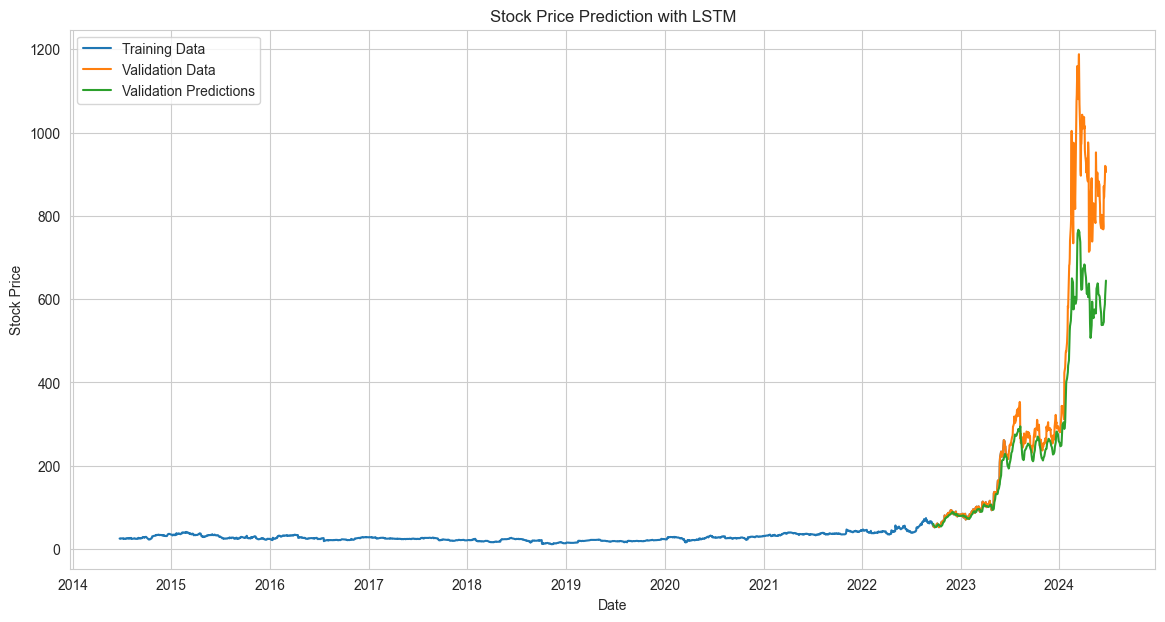

In [13]:
# 7. Print & Visualize the results
valid_rmse = np.sqrt(mean_squared_error(valid_set['Close/Last'].values[time_steps:], predicted_y_valid))
print(f"LSTM RMSE on validation set: {valid_rmse}")

plt.figure(figsize=(14, 7))
plt.plot(train_set['Date'], train_set['Close/Last'], label='Training Data')
plt.plot(valid_set['Date'][time_steps:], valid_set['Close/Last'].values[time_steps:], label='Validation Data')
plt.plot(valid_set['Date'][time_steps:], predicted_y_valid, label='Validation Predictions')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('Stock Price Prediction with LSTM')
plt.legend()
plt.show()